In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *
import mne
import seaborn as sns

**Deux choses :**
- Trouver la modulante des fuseaux dans le signal cérébral
- Voir si cette modulante est modulée par la respi

**Pour trouver la modulante des fuseaux :**
- Récupérer la phase de différentes bandes de fréquence
- Compter le timing des fuseaux par rapport à ces phases

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [3]:
def get_da_phase(da, stage, f_start = 0., f_stop = 6, step = 0.1):
    chan_sig = da.loc[stage,'Fp2-C4',:].values
    da_precompute = None
    filter_width = 0.4

    freqs = np.arange(f_start * 10, f_stop*10, filter_width * 10) / 10
    for fi in freqs:
        fi = round(fi, 1)
        # print(fi)
        if fi - filter_width <= 0:
            low = None
        else:
            low = fi - filter_width
        high = fi + filter_width
        # print(low , high)
        fi_filtered = gh.filter_sig(chan_sig, fs=srate, low = low, high = high)
        fi_phase = gh.get_phase(fi_filtered)
        if da_precompute is None:
            da_precompute = gh.init_da({'feature':['phase','filtered'],'freq':freqs,'time':da.coords['time'].values})
        da_precompute.loc['phase',fi,:] = fi_phase
        da_precompute.loc['filtered',fi,:] = fi_filtered
    return da_precompute

In [4]:
def load_spindles(patient , stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    return spindles

In [5]:
def count_spindles_by_phase_bin(nbins, patient, spindles, df_cycles, cycle_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'norm' , 'no')
    phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
    phase_count_norm = phase_count_norm.to_frame().T
    phase_count_norm.insert(0 , 'norm' , 'yes')
    
    df_concat = pd.concat([phase_count, phase_count_norm], axis = 0)
    
    df_concat.insert(0 , 'patient', patient)

    return df_concat

In [6]:
def get_cycles_from_phase(phase):
    gradient = -1
    cycles = np.where(np.gradient(phase) < gradient)[0][::2]
    
    c = []
    for i in range(0, cycles.size):
        if i == cycles.size -1:
            break
        start_idx = cycles[i]
        stop_idx =  cycles[i+1]
        start_time = start_idx / srate
        stop_time = stop_idx / srate
        duration = stop_time - start_time
        c.append([start_idx ,stop_idx, start_time, stop_time , duration])
    df_features_of_fi = pd.DataFrame(c, columns = ['start idx','stop idx', 'start time', 'stop time', 'duration'])
    return df_features_of_fi

In [7]:
def which_cycle_find_spindle(spindles, df_cycles):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [8]:
def mi_from_fi(fi, da, spindles, show = False):
    df_features_of_fi = get_cycles_from_phase(phase=da.loc['phase',fi,:])
    cycles_with_spindle = which_cycle_find_spindle(spindles, df_features_of_fi)
    count_by_bin_18 = count_spindles_by_phase_bin(nbins=18, patient=patient, spindles=spindles, df_cycles=df_features_of_fi, cycle_spindled=cycles_with_spindle)
    values_18 = count_by_bin_18[count_by_bin_18['norm'] == 'yes'].drop(columns=['patient','norm']).values[0]
    mi = gh.Modulation_Index(values_18, show = show)
    return mi

In [9]:
def get_fi_mi_from_patient(patient, start=0.2, stop = 2, step = 0.1):
    stage = 'N2'
    da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
    da_precompute = get_da_phase(da_data, stage, f_start = start, f_stop = stop, step = step)
    spindles = load_spindles(patient , stage)

    rows = []
    for fi in da_precompute.coords['freq'].values:
        print(fi)
        mi = mi_from_fi(fi=fi, da=da_precompute, spindles=spindles)
        rows.append([patient, fi, mi])
    df_fi_mi = pd.DataFrame(rows, columns = ['patient','freq', 'mi'])
    
    return df_fi_mi

In [10]:
concat = []
for patient in patients:
    df_patient = get_fi_mi_from_patient(patient)
    concat.append(df_patient)
df_all = pd.concat(concat)

0.2
0.6
1.0
1.4
1.8
0.2
0.6
1.0
1.4
1.8
0.2
0.6
1.0
1.4
1.8
0.2


/tmp/ipykernel_3073186/47218992.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_3073186/858950885.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_3073186/858950885.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


0.6
1.0
1.4
1.8
0.2
0.6
1.0
1.4
1.8
0.2
0.6
1.0
1.4
1.8


KeyboardInterrupt: 

In [ ]:
# df_all.to_excel('../df_analyse/fi_mi_all.xlsx')

In [ ]:
# df_all = pd.read_excel('../df_analyse/fi_mi_all.xlsx', index_col = 0)

In [ ]:
df_all

In [ ]:
sns.pointplot(data=df_all , x='freq', y = 'mi')

In [ ]:
fig, ax = plt.subplots()
sns.pointplot(data=df_all , x='freq', y = 'mi', hue = 'patient',ax=ax)
ax.set_title('Modulation of Spindles Events by Frequency bands')
ax.legend(loc = 'right')
ax.set_ylabel('Modulation Index')
ax.set_xlabel('Freq [Hz]')
# plt.savefig('../presentation_4/modulogram_spindles', bbox_inches = 'tight')
plt.show()

In [ ]:
sns.pointplot(data=df_all.groupby('freq').mean().reset_index() , x='freq', y = 'mi')

In [ ]:
concat = []
for patient in patients:
    concat.append(df_all[(df_all['patient'] == patient) & (df_all['freq'] <= 6)].sort_values(by = 'mi', ascending = False).iloc[0,:])
best_modulant_by_patient = pd.concat(concat, axis = 1).T

In [ ]:
best_modulant_by_patient

In [ ]:
best_modulant_by_patient.mean()

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [ ]:
da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc').sel(stage = 'N2', chan = ['Fp2-C4','DEBIT'])

In [ ]:
da_data

In [ ]:
da_data.loc[:,0:60].plot.line(x='time', hue = 'chan')

In [ ]:
filtered_resp = gh.filter_sig(da_data.loc['DEBIT',:].values, fs=srate, low = 0.1, high = 0.7)
phase_resp = gh.get_phase(filtered_resp)

In [ ]:
plt.plot(da_data.loc['DEBIT',:].values[0:srate*30])
plt.plot(filtered_resp[0:srate*30])
plt.plot(phase_resp[0:srate*30])

In [ ]:
eeg_sig = da_data.loc['Fp2-C4',:].values
eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = 3.5, high = 4.5)
envelope_eeg_filtered = gh.get_amp(eeg_filtered)

In [ ]:
plt.plot(eeg_filtered[0:5*srate])
plt.plot(envelope_eeg_filtered[0:5*srate])

In [ ]:
f, Pxx = signal.welch(envelope_eeg_filtered, fs = srate, nperseg = int(srate * 100))

In [ ]:
plt.plot(f[0:100], Pxx[0:100])

In [ ]:
pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)

In [ ]:
gh.Modulation_Index(pac_distribution, show = True)

In [ ]:
def get_mi_fi_resp(phase_resp, eeg_sig, fi, half_width = 1, show = False):
    low = fi - half_width
    high = fi + half_width
    
    if low <= 0:
        low = None
    
    eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = low, high = high)
    envelope_eeg_filtered = gh.get_amp(eeg_filtered)
    pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)
    mi = gh.Modulation_Index(pac_distribution, show = show)
    # return mi
    return mi, eeg_filtered, envelope_eeg_filtered

In [ ]:
rows = []
da_features = None
freqs = np.arange(1,100,1)
for fi in freqs:
    if fi in np.arange(0,100,10):
        print(fi)
    for half_width in [0.1,0.5,1,2]:
        mi, eeg_filtered, envelope_eeg_filtered = get_mi_fi_resp(phase_resp, eeg_sig, fi=fi, half_width=half_width,  show =False)
        if da_features is None:
            da_features = gh.init_da({'features':['filtered','envelope'], 'width':[0.1,0.5,1,2], 'freq':freqs, 'time':gh.time_vector(eeg_filtered, srate)})
        da_features.loc['filtered',half_width,fi,:] = eeg_filtered
        da_features.loc['envelope',half_width,fi,:] = envelope_eeg_filtered
        rows.append([half_width, fi, mi])
df_mi_resp = pd.DataFrame(rows, columns = ['width','freq','mi'])

In [ ]:
da_features = da_features.astype('float32')

In [ ]:
da_features

In [ ]:
da_features.loc['filtered',:,[5,10,20],0:1].plot.line(x='time', hue = 'width', row = 'freq')

In [ ]:
da_features.loc['envelope',:,[5,10,20],0:10].plot.line(x='time', hue = 'width', row = 'freq')

In [ ]:
da_features.loc[:,:,[5,10,20],0:5].plot.line(x='time', hue = 'features', col = 'freq', row = 'width')

In [ ]:
sns.lineplot(data=df_sel_bande, x='freq' , y = 'mi')

In [ ]:
df_sel_bande = df_mi_resp[df_mi_resp['width'] == 0.5]

In [ ]:
get_mi_fi_resp(phase_resp, eeg_sig, fi=80,  show =True)

In [ ]:
da_features.loc['filtered',[5,15,25,35,65,85,95],0:10].plot.line(x='time')

In [ ]:
del da_features

In [ ]:
da_features

In [ ]:
eeg_sig = da_data.loc['Fp2-C4',:].mean('chan').values

In [ ]:
eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = 1.8 , high =4)

In [ ]:
eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)

In [ ]:
plt.plot(eeg_sig[0:2*srate])
plt.plot(eeg_sig_filtered[0:2*srate])

In [ ]:
plt.figure(figsize = (20,15))
plt.plot(eeg_sig_filtered[0:10*srate])
plt.plot(eeg_sig_filtered_phase[0:10*srate])

In [ ]:
fig, axs = plt.subplots(ncols = 2 , figsize = (30,15))
fi = 5
for width in [0.1 , 0.5 , 1 , 1.5, 2]:
    eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = fi - width  , high = fi + width)
    eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)
    axs[0].plot(eeg_sig_filtered[5*srate:int(6.5*srate)], label = width)
    axs[1].plot(eeg_sig_filtered_phase[5*srate:int(6.5*srate)], label = width)
axs[0].legend()
plt.show()

In [ ]:
filtered_sigma = gh.filter_sig(eeg_sig, fs = srate, low = 10, high = 15)

In [ ]:
plt.plot(filtered_sigma[0*srate : 5 * srate])

## PSD of sigma envelope

In [10]:
da_pxx_of_amplitudes = None
f_low = 12
f_high = 15
for patient in patients:
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')
    sigma_power = da.loc['raw',f_low:f_high,:].sum('freqs').values
    f, Pxx = gh.spectre(sigma_power, srate, wsize = 50)
    if da_pxx_of_amplitudes is None:
        da_pxx_of_amplitudes = gh.init_da({'participant':patients, 'freqs':f})
    da_pxx_of_amplitudes.loc[patient, :] = Pxx

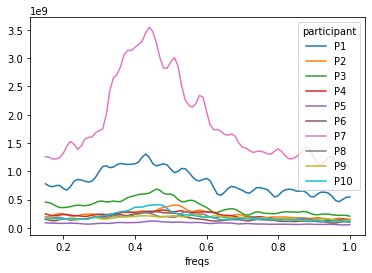

In [11]:
da_pxx_of_amplitudes.loc[:,0.15:1].plot.line(x='freqs',hue = 'participant')

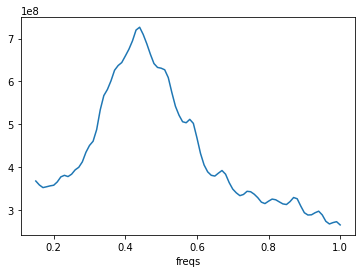

In [12]:
da_pxx_of_amplitudes.loc[:,0.15:1].mean('participant').plot()

In [13]:
for participant in patients:
    print(da_pxx_of_amplitudes.loc[participant,0.15:1].idxmax().values)

0.43
0.51
0.46
0.48
0.45
0.44
0.44
0.54
0.5700000000000001
0.47000000000000003


In [14]:
da_pxx_all = xr.load_dataarray('../dataarray/da_pxx_all.nc')

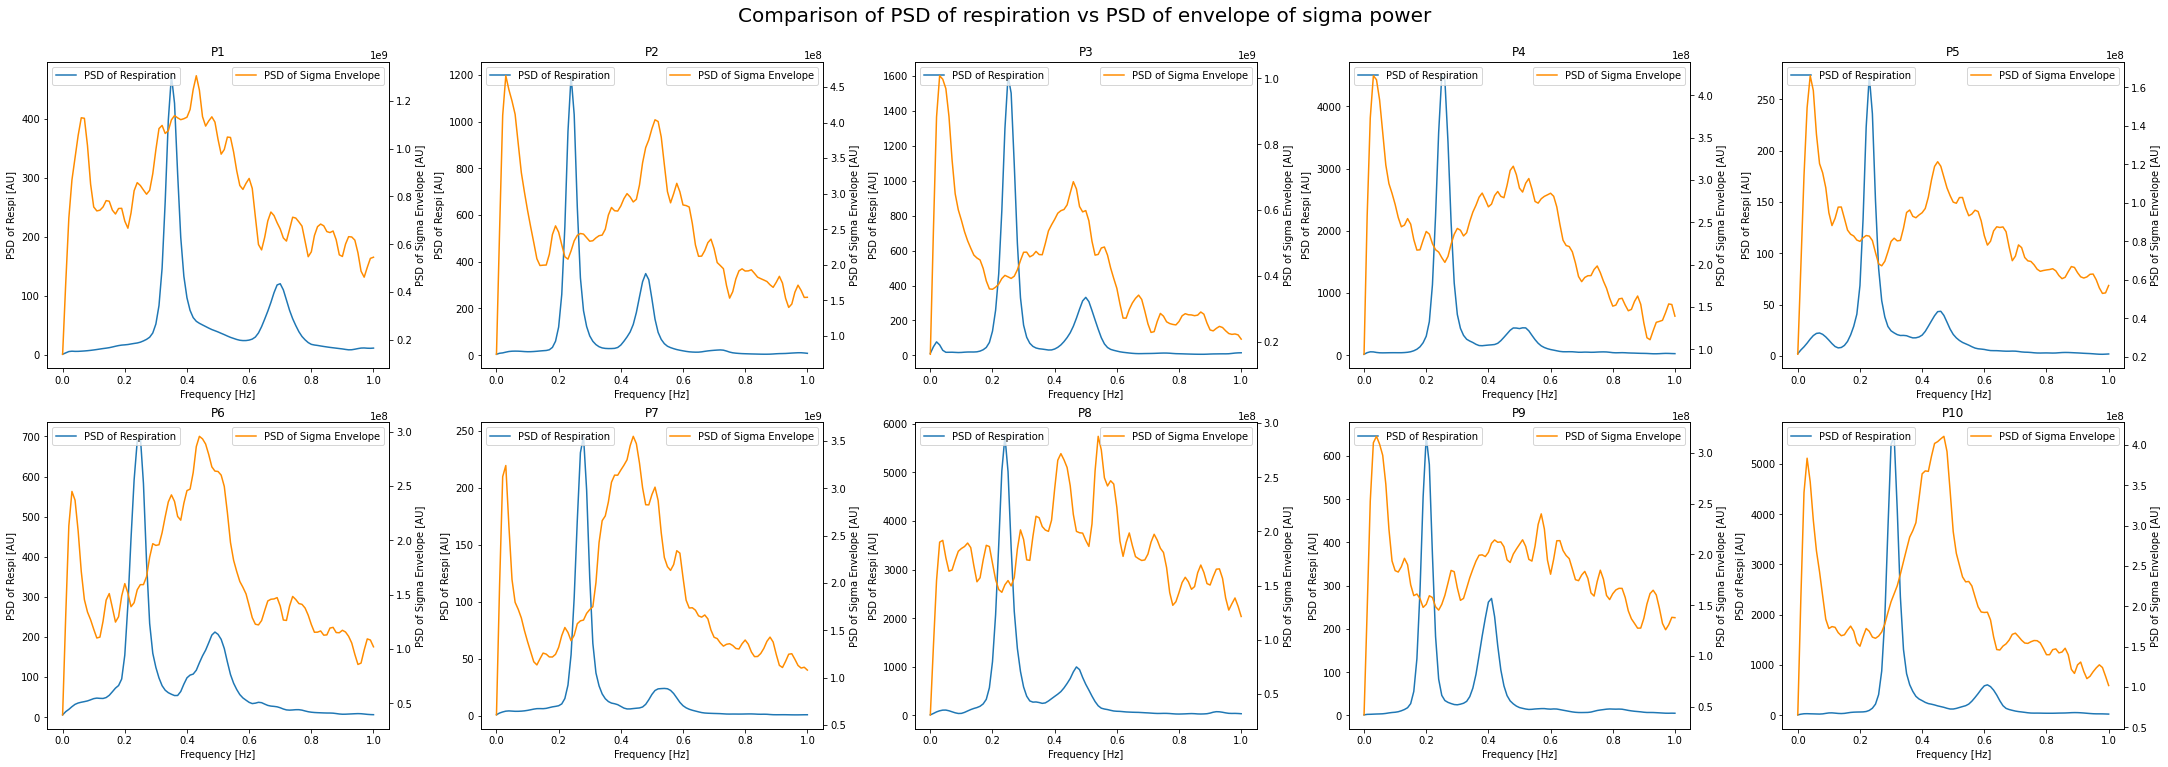

In [15]:
fig , axs = plt.subplots(nrows = 2, ncols = 5, figsize = (30,10), constrained_layout = True)
fig.suptitle('Comparison of PSD of respiration vs PSD of envelope of sigma power', fontsize = 20, y = 1.05)
for row, sublist in enumerate([patients[:5] , patients[5:]]):
    for col, participant in enumerate(sublist):
        ax = axs[row, col]
        f = da_pxx_all.coords['freq'].loc[0:1].values
        psd_rsp = da_pxx_all.loc[participant,'N2','DEBIT','raw',0:1].values
        psd_sigma_power_envelope = da_pxx_of_amplitudes.loc[participant,0:1].values
        ax.plot(f, psd_rsp, label = 'PSD of Respiration')
        ax2 = ax.twinx()
        ax2.plot(f, psd_sigma_power_envelope, label = 'PSD of Sigma Envelope', color = 'darkorange')
        ax.set_title(participant)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD of Respi [AU]')
        ax2.set_ylabel('PSD of Sigma Envelope [AU]')
        ax.legend(loc=2)
        ax2.legend(loc = 1)
# plt.savefig('../presentation_4/psd_sigma_env_respi', bbox_inches = 'tight')
plt.show()    

In [16]:
high_modulation = gh.simu_pac_sig(100, 0.5, 10, 15, 1 , 50, 120, srate)
low_modulation = gh.simu_pac_sig(0.05, 0.5, 10, 15, 1 , 50, 120, srate)

In [17]:
high_mi = gh.raw_to_mi(sig=high_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)
low_mi = gh.raw_to_mi(sig=low_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)

In [18]:
high_mi

0.04112496582951065

In [19]:
low_mi

0.0017928232370287855

In [20]:
def raw_to_mi(sig, modulant_freqs, target_freqs, srate, N=18):
    sig = sig - np.mean(sig)
    phase_modulant, amp_target = gh.get_phase_amplitude_vectors(sig=sig, modulant_freqs=modulant_freqs, target_freqs=target_freqs, srate=srate)
    pac_distribution = gh.get_amplitude_distribution(phase_modulant, amp_target, N)
    mi = gh.Modulation_Index(pac_distribution, show = True)
    return mi

0.0017928232370287855

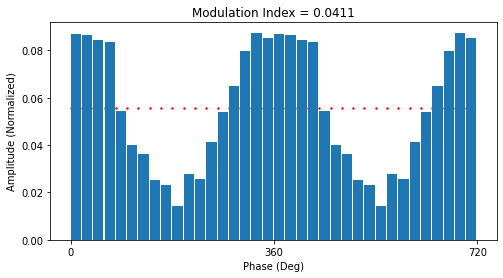

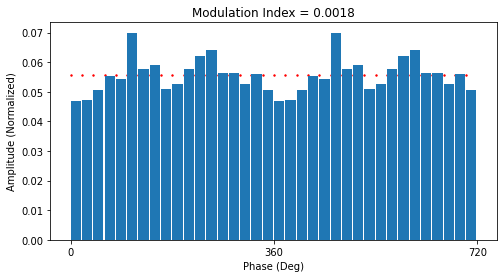

In [21]:
raw_to_mi(sig=high_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)
raw_to_mi(sig=low_modulation, modulant_freqs = (0.1,1.5), target_freqs = (10,20), srate=srate)

In [22]:
da = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')

In [23]:
da

<xarray.DataArray (normalisation: 2, freqs: 40, time: 1171200)>
array([[[2.99934277e+04, 3.00634551e+04, 2.99889219e+04, ...,
         1.07230656e+05, 1.08852359e+05, 1.09950844e+05],
        [2.84692188e+04, 2.85382090e+04, 2.84705742e+04, ...,
         1.03090086e+05, 1.04591820e+05, 1.05595898e+05],
        [2.70250664e+04, 2.70948164e+04, 2.70357129e+04, ...,
         9.94168984e+04, 1.00786875e+05, 1.01683906e+05],
        ...,
        [8.68554883e+03, 8.70840039e+03, 8.69086328e+03, ...,
         2.39298125e+04, 2.45467324e+04, 2.50401055e+04],
        [8.58875293e+03, 8.61773047e+03, 8.60715820e+03, ...,
         2.32510234e+04, 2.38488145e+04, 2.43265703e+04],
        [8.45978906e+03, 8.49211914e+03, 8.48572559e+03, ...,
         2.31433379e+04, 2.36890605e+04, 2.41183555e+04]],

       [[3.86462498e+00, 3.87458396e+00, 3.86398411e+00, ...,
         1.48490353e+01, 1.50796680e+01, 1.52358904e+01],
        [3.64785719e+00, 3.65766883e+00, 3.64804983e+00, ...,
         1.42601776e+01, 1.44737492e+01, 1.46165457e+01],
        [3.44247484e+00, 3.45239449e+00, 3.44398904e+00, ...,
         1.37377892e+01, 1.39326229e+01, 1.40601959e+01],
        ...,
        [8.34292352e-01, 8.37542176e-01, 8.35048139e-01, ...,
         3.00227857e+00, 3.09001470e+00, 3.16018057e+00],
        [8.20526361e-01, 8.24647427e-01, 8.23143899e-01, ...,
         2.90574360e+00, 2.99075937e+00, 3.05870414e+00],
        [8.02185535e-01, 8.06783438e-01, 8.05874169e-01, ...,
         2.89042902e+00, 2.96803975e+00, 3.02909255e+00]]], dtype=float32)
Coordinates:
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * time           (time) float64 0.0 0.007812 0.01562 ... 9.15e+03 9.15e+03
  * normalisation  (normalisation) object 'raw' 'normal'

In [34]:
da_pxx_env = None
for patient in patients:
    da = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
    data = da.loc['N2',['Fp2-C4','Fp1-C3'],:].mean('chan').dropna(dim='time').values
    sigma_filtered = gh.filter_sig(data, low = 11 , high = 15, fs=srate )
    sigma_env = gh.get_amp(sigma_filtered)
    respi = da.loc['N2','DEBIT',:].dropna(dim='time').values
    f, Pxx = gh.spectre(sigma_env, srate=srate, wsize = 50)
    f, Cxy = gh.coherence(sigma_env, respi,  srate=srate, wsize = 50)
    if da_pxx_env is None:
        da_pxx_env = gh.init_da({'participant':patients, 'mode':['pxx','cxy'], 'freq':f})
    da_pxx_env.loc[patient, 'pxx', :] = Pxx  
    da_pxx_env.loc[patient, 'cxy', :] = Cxy  

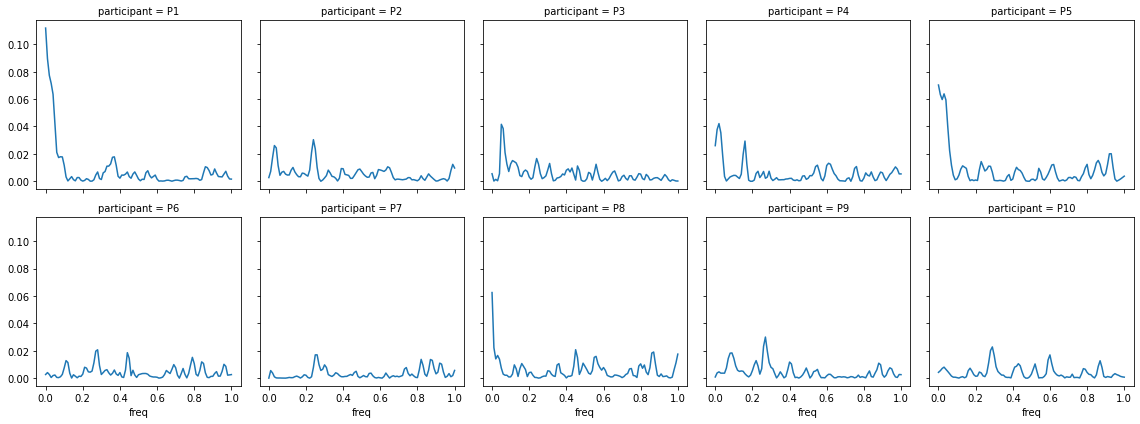

In [35]:
da_pxx_env.loc[:,'cxy',0:1].plot.line(x='freq',col = 'participant', col_wrap = 5)

In [36]:
da_pxx_all = xr.load_dataarray('../dataarray/da_pxx_all.nc')

In [37]:
def reduce(sig):
    return sig / np.std(sig)

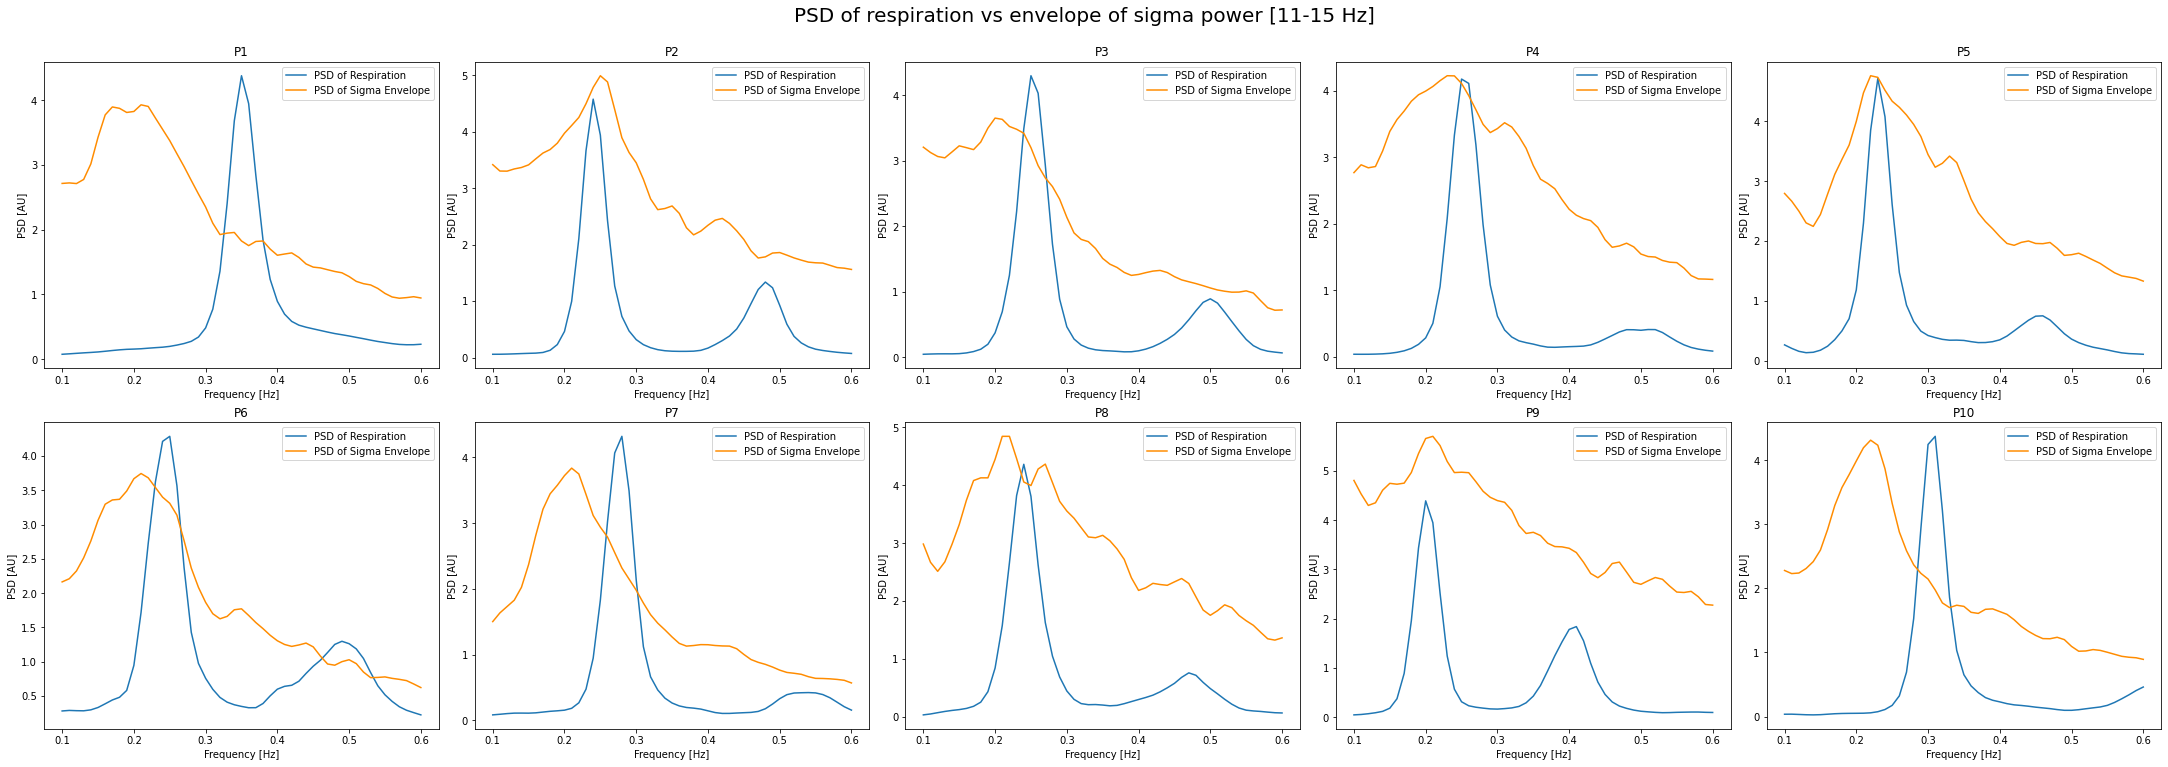

In [97]:
fig , axs = plt.subplots(nrows = 2, ncols = 5, figsize = (30,10), constrained_layout = True)
fig.suptitle('PSD of respiration vs envelope of sigma power [11-15 Hz]', fontsize = 20, y = 1.05)
lf = 0.1
hf = 0.6
for row, sublist in enumerate([patients[:5] , patients[5:]]):
    for col, participant in enumerate(sublist):
        ax = axs[row, col]
        f = da_pxx_all.coords['freq'].loc[lf:hf].values
        psd_rsp = reduce(da_pxx_all.loc[participant,'N2','DEBIT','raw',lf:hf].values)
        psd_sigma_power_envelope = reduce(da_pxx_env.loc[participant,'pxx',lf:hf].values)
        cxx_sigma_resp = da_pxx_env.loc[participant,'cxy',lf:hf].values
        ax.plot(f, psd_rsp, label = 'PSD of Respiration')
        ax.plot(f, psd_sigma_power_envelope, label = 'PSD of Sigma Envelope', color = 'darkorange')
        ax.set_title(participant)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD [AU]')
        ax.legend(loc = 1)

        # ax2 = ax.twinx()
        # ax2.plot(f, cxx_sigma_resp, label = 'Cxy Sigma Env & Respi', color = 'g')
        # ax2.set_ylabel('Coherence Sigma Env & Respi')
        # ax2.set_ylim(-0.001,0.1)
        # ax2.legend(loc = 1)
        # ax.set_ylim(-0.001, 7)
        

# plt.savefig('../presentation_4/psd_sigma_env_respi_pxx_only', bbox_inches = 'tight')
plt.show()    

In [40]:
da_pxx_envelope_multibands = None
bands = {
    'theta':(4,8),
    'alpha':(8,12),
    'sigma':(11,15),
    '10_20':(10,20),
    '15_20':(15,20),
    '20_25':(20,25),
    'beta':(15,30),
    'gamma_low':(30,45),
    'gamma_high':(55,80)
}
for patient in patients:
    print(patient)
    for stage in compute_stages:
        for band in bands.keys():
            da = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
            filtered = gh.filter_sig(da.loc[stage,['Fp2-C4','Fp1-C3'],:].mean('chan').dropna(dim='time').values, low = bands[band][0] , high = bands[band][1], fs=srate )
            env = gh.get_amp(filtered)
            f, Pxx = gh.spectre(env, srate=srate, wsize = 50)
            if da_pxx_envelope_multibands is None:
                da_pxx_envelope_multibands = gh.init_da({'participant':patients, 'stage':compute_stages, 'band':list(bands.keys()), 'mode':['raw','reduced'], 'freq':f})
            da_pxx_envelope_multibands.loc[patient, stage, band, 'raw', :] = Pxx  
            da_pxx_envelope_multibands.loc[patient, stage, band, 'reduced',  :] = reduce(Pxx)

P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


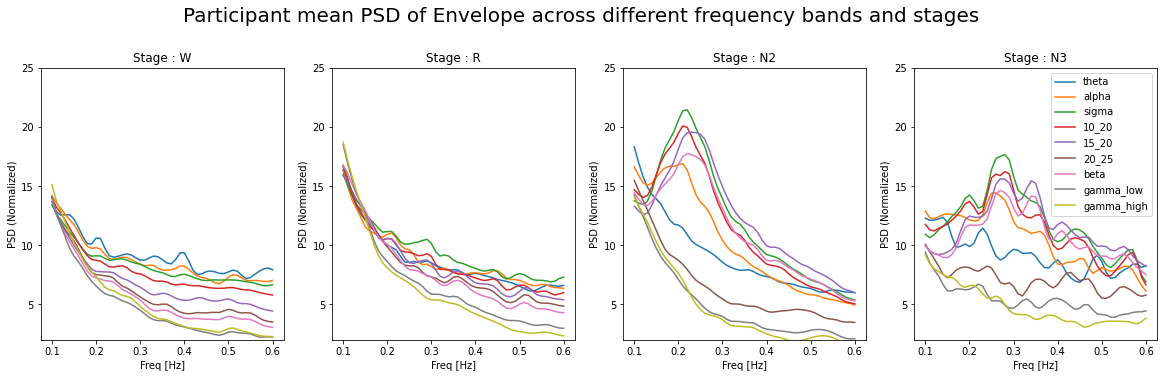

In [41]:
fig, axs = plt.subplots(ncols = len(compute_stages), figsize = (20,5))
fig.suptitle('Participant mean PSD of Envelope across different frequency bands and stages', fontsize = 20, y = 1.05)
for col, stage in enumerate(compute_stages):
    ax = axs[col]
    for band in bands.keys():
        data = da_pxx_envelope_multibands.loc[:,stage,band,'reduced',0.1:0.6].mean('participant')
        ax.plot(data.coords['freq'].loc[0.1:0.6], data, label = band)
    ax.set_ylim(2,25)
    ax.set_title(f'Stage : {stage}')
    ax.set_xlabel('Freq [Hz]')
    ax.set_ylabel('PSD (Normalized)')
ax.legend()
# plt.savefig('../presentation_4/psd_env_freqs_mean_participant', bbox_inches = 'tight')

# ax.set_title('


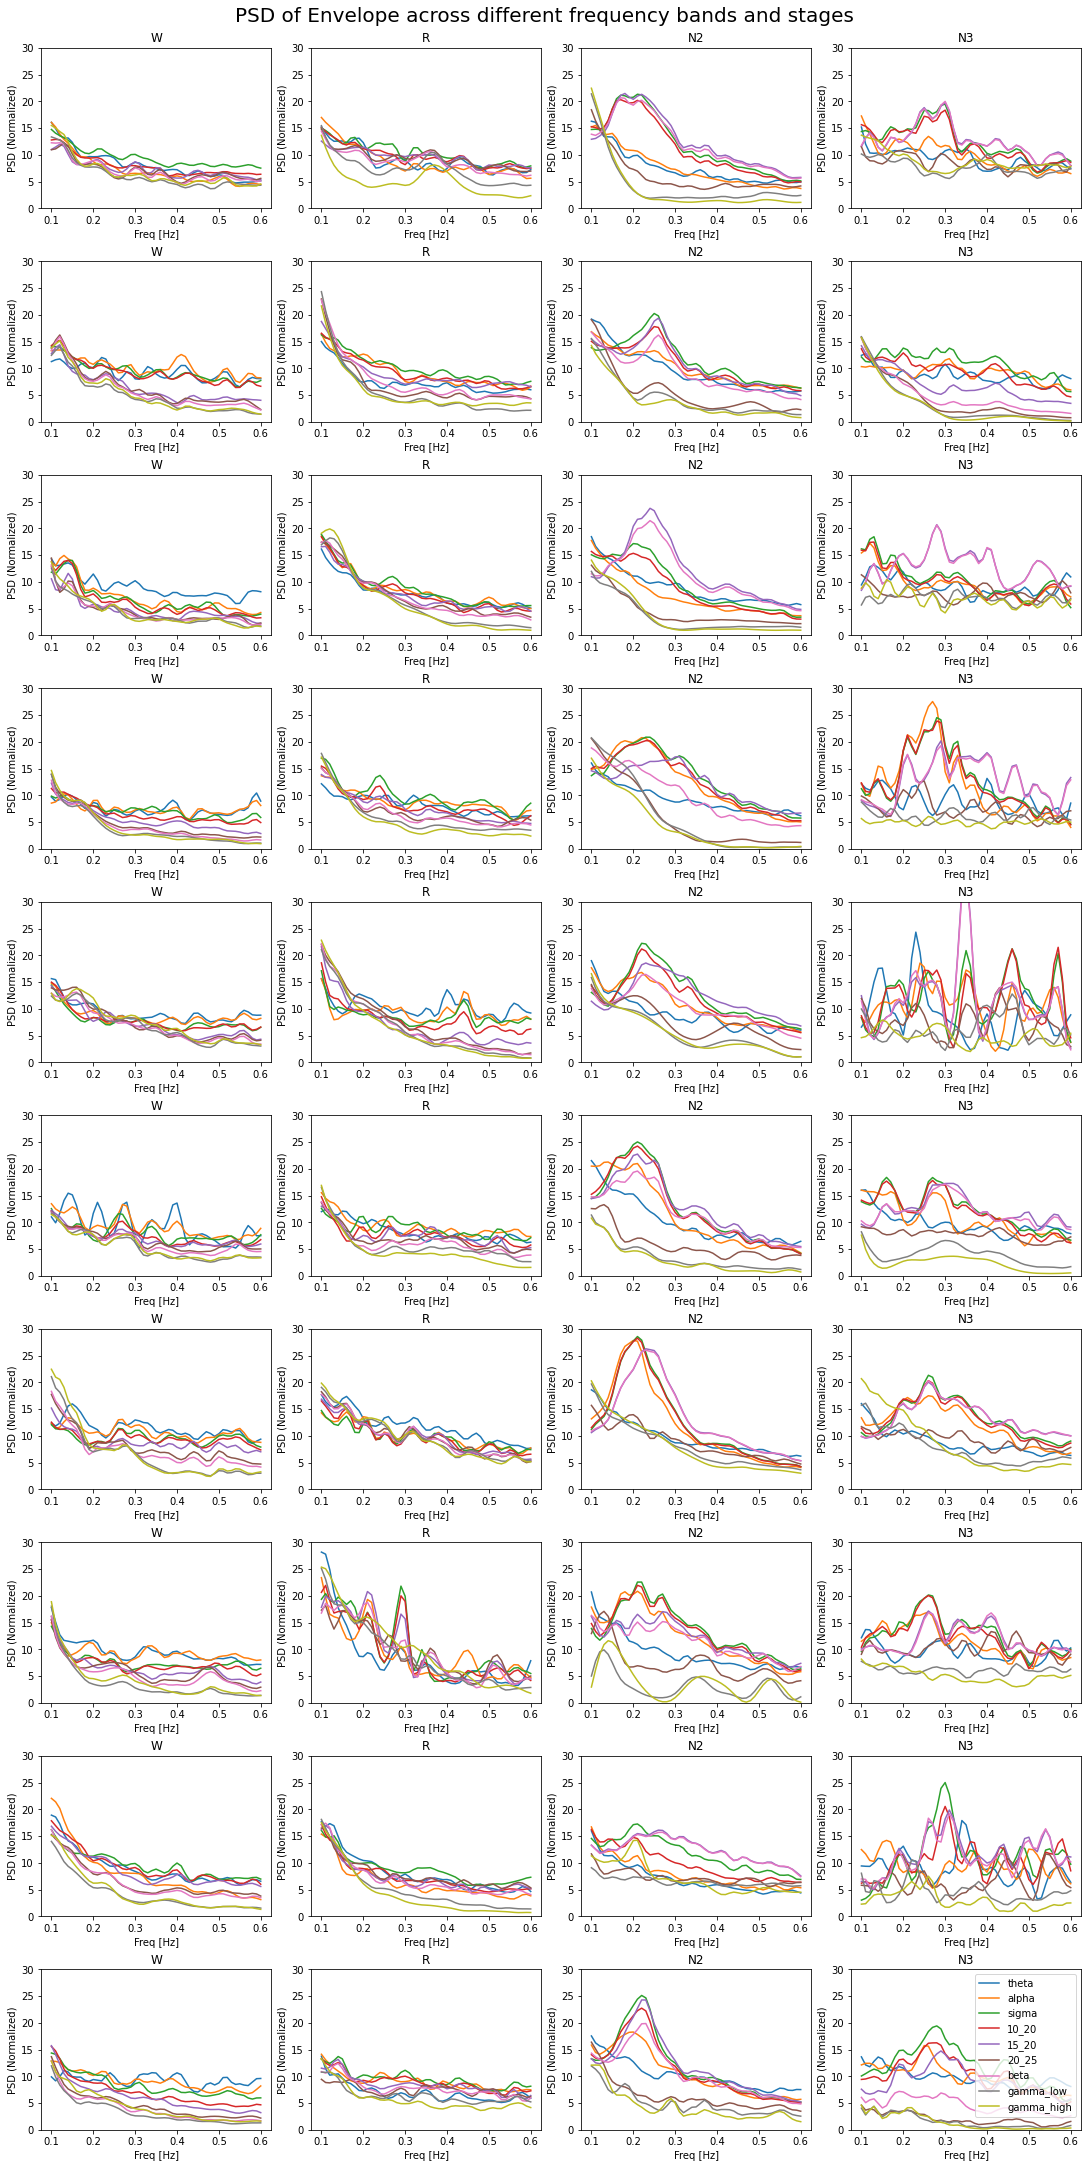

In [42]:
fig, axs = plt.subplots(nrows = len(patients), ncols = len(compute_stages), figsize = (15,30), constrained_layout = True)
fig.suptitle('PSD of Envelope across different frequency bands and stages', fontsize = 20)

for row, patient in enumerate(patients):
    for col, stage in enumerate(compute_stages):
        ax = axs[row, col]
        for band in bands.keys():
            data = da_pxx_envelope_multibands.loc[patient,stage,band,'reduced',0.1:0.6]
            ax.plot(data.coords['freq'].loc[0.1:0.6], data, label = band)
        ax.set_ylim(0,30)
        ax.set_title(stage)
        ax.set_xlabel('Freq [Hz]')
        ax.set_ylabel('PSD (Normalized)')
ax.legend()
# plt.savefig('../presentation_4/psd_env_freqs_detailed', bbox_inches = 'tight')

# ax.set_title('

In [ ]:
rows = []
for patient in patients:
    for stage in compute_stages:
        for band in bands.keys():
            rows.append([patient, stage, band, float(da_pxx_envelope_multibands.loc[patient,stage,band,'raw',0.1:].idxmax().values), float(da_pxx_envelope_multibands.loc[patient,stage,band,'raw',0.1:].max().values)])
df = pd.DataFrame(rows, columns = ['patient','stage','band','idxmax','max'])

In [ ]:
df

,patient,stage,band,idxmax,max
0,P1,W,theta,0.10,1.245466
1,P1,W,alpha,0.10,0.969765
2,P1,W,sigma,0.10,0.160142
3,P1,W,10_20,0.11,0.236134
4,P1,W,15_20,0.12,0.063194
...,...,...,...,...,...
355,P10,N3,15_20,0.29,0.053982
356,P10,N3,20_25,0.10,0.026267
357,P10,N3,beta,0.19,0.060862
358,P10,N3,gamma_low,0.13,0.036967


Text(0, 0.5, 'Max Freq of PSD')

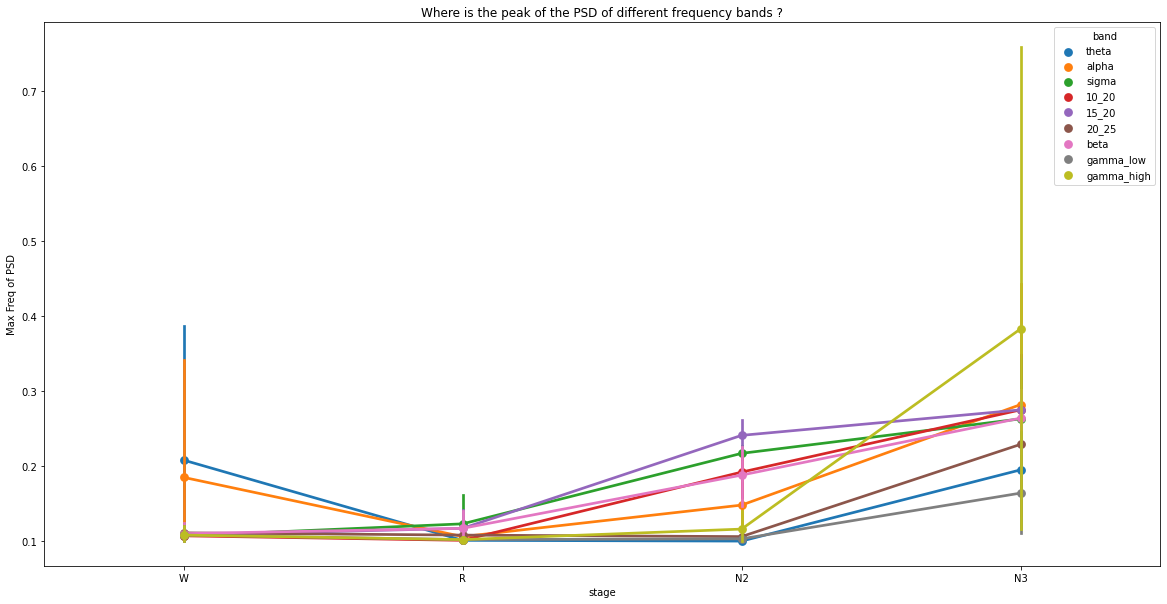

In [ ]:
fig ,ax = plt.subplots(figsize = (20,10))
sns.pointplot(data=df, x='stage', y='idxmax', hue = 'band', ax=ax)
ax.set_title('Where is the peak of the PSD of different frequency bands ?')
ax.set_ylabel('Max Freq of PSD')

In [80]:
def get_psd_env_features(freq_modulant):
    t, simu = gh.simu_pac_sig(pac_value=50, freq_modulant=freq_modulant, amp_modulant=20, freq_modulated=80, amp_modulated=2, noise_amp=5, duration=300, srate=srate)
    envelope = gh.get_amp(simu)
    f, Pxx_envelope = gh.spectre(envelope, srate, 10)
    return t, simu, envelope, f, Pxx_envelope

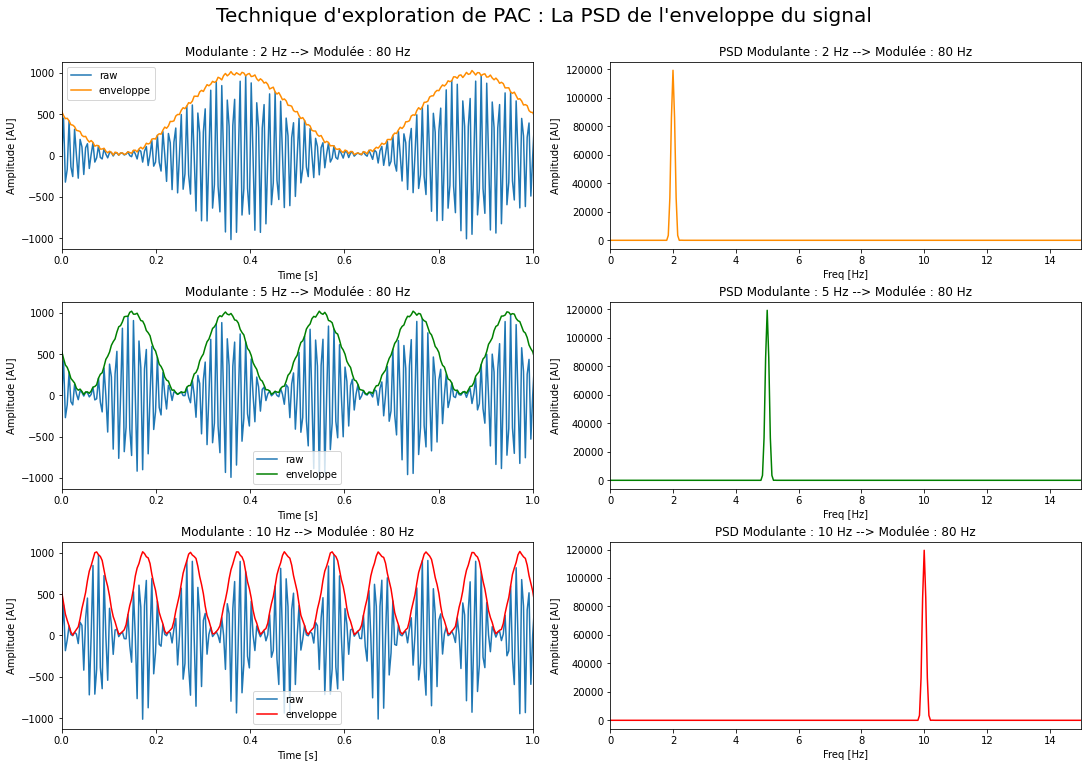

In [91]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15,10), constrained_layout = True)
fig.suptitle("Technique d'exploration de PAC : La PSD de l'enveloppe du signal", fontsize = 20, y = 1.05)

for row, freq_modulant in enumerate([2, 5 , 10]):
    if row == 0:
        color = 'darkorange'
    elif row == 1:
        color = 'g'
    elif row == 2:
        color = 'r'

    t, simu, envelope, f, Pxx_envelope = get_psd_env_features(freq_modulant)
    ax = axs[row, 0]
    ax.plot(t,simu , label = 'raw')
    ax.plot(t, envelope, label = 'enveloppe', color = color)
    ax.set_title(f'Modulante : {freq_modulant} Hz --> Modulée : 80 Hz')
    ax.set_xlim(0,1)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude [AU]')
    ax.legend()


    ax = axs[row, 1]
    ax.plot(f , Pxx_envelope, color = color)
    ax.set_title(f'PSD Modulante : {freq_modulant} Hz --> Modulée : 80 Hz')
    ax.set_xlabel('Freq [Hz]')
    ax.set_ylabel('Amplitude [AU]')
    ax.set_xlim(0,15)

# plt.savefig('../presentation_4/simulation_psd_enveloppe', bbox_inches = 'tight')
    